In [ ]:
### pyspark data frame : load data, explore and pre-proecess it. 

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, desc , col, max, struct
import matplotlib.pyplot as plts

In [ ]:
###create spark session : 

In [2]:
spark = SparkSession.builder.appName('music_database').getOrCreate()

In [29]:
#load the data

In [3]:
listening_path = 'G:\\.shortcut-targets-by-id\\1ZhV5LxuRBYiD81HJHQTheQawXZ5MkPim\\dataset\\listenings.csv'
genre_path = 'G:\\.shortcut-targets-by-id\\1ZhV5LxuRBYiD81HJHQTheQawXZ5MkPim\\dataset\\genre.csv'

listening_df = spark.read.format('csv').option('inferSchema', True).option('header', True).load(listening_path)
genre_df = spark.read.format('csv').option('inferSchema', True).option('header', True).load(genre_path)

In [ ]:
#explore data:

In [30]:
listening_df.show()

+-----------+-------------+--------------------+---------------+--------------------+
|    user_id|         date|               track|         artist|               album|
+-----------+-------------+--------------------+---------------+--------------------+
|000Silenced|1299680100000|           Price Tag|       Jessie J|         Who You Are|
|000Silenced|1299679920000|Price Tag (Acoust...|       Jessie J|           Price Tag|
|000Silenced|1299679440000|Be Mine! (Ballad ...|          Robyn|            Be Mine!|
|000Silenced|1299679200000|            Acapella|          Kelis|            Acapella|
|000Silenced|1299675660000|   I'm Not Invisible|      The Tease|   I'm Not Invisible|
|000Silenced|1297511400000|Bounce (Feat NORE...|       MSTRKRFT|         Fist of God|
|000Silenced|1294498440000|Don't Stop The Mu...|        Rihanna|Addicted 2 Bassli...|
|000Silenced|1292438340000|               ObZen|      Meshuggah|               ObZen|
|000Silenced|1292437740000|   Yama's Messengers|      

In [34]:
genre_df.show()

+--------------------+-----+
|              artist|genre|
+--------------------+-----+
|                Muse| rock|
|             Nirvana| rock|
|            Bon Jovi| rock|
|          The Police| rock|
|                Kiss| rock|
|       Guns N' Roses| rock|
|         Rusted Root| rock|
|Katrina and the W...|  pop|
|         The Beatles| rock|
|        Hall & Oates|  pop|
|        Otis Redding| soul|
|         Marvin Gaye| soul|
|     The Cranberries| rock|
|            Survivor| rock|
|       Fleetwood Mac|blues|
|           Radiohead| rock|
|                Toto| rock|
|                  U2| rock|
|Creedence Clearwa...| rock|
|                 REM| rock|
+--------------------+-----+
only showing top 20 rows



In [36]:
def get_shape(df):
    return (df.count()), (len(df.columns))

In [41]:
listening_df_shape = get_shape(listening_df)
genre_df_shape = get_shape(genre_df)
listening_df_shape, genre_df_shape

((14650594, 5), (138432, 2))

In [42]:
listening_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- date: long (nullable = true)
 |-- track: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- album: string (nullable = true)



In [43]:
genre_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- genre: string (nullable = true)



In [4]:
#pre-process data :  1. join dataframes based on artist column to create one big music dataframe | 2. drop rows with NaN values | 3.drop date column

In [44]:
music_data = listening_df.join(genre_df, how = 'inner', on=['artist'])
music_data.na.drop()
music_data.drop('date')

DataFrame[artist: string, user_id: string, track: string, album: string, genre: string]

In [45]:
###Create langchain agent for data exploration and analysis: 

In [46]:
from langchain_experimental.agents.agent_toolkits import create_spark_dataframe_agent
from langchain.agents import AgentExecutor
from langchain.llms import OpenAI
from pyspark.sql import SparkSession
from langchain.chat_models import ChatOpenAI

In [47]:
#get openai_api_key

In [48]:
import os
OPENAI_API_KEY= os.getenv('OPENAI_API_KEY')

In [49]:
llm_model = "gpt-3.5-turbo-0301"
llm = ChatOpenAI(temperature=0, model=llm_model)

In [50]:
#create pyspark agent:

In [51]:
agent = create_spark_dataframe_agent(llm=llm, df=music_data, verbose=True)

In [52]:
agent.run("how to find all of the records of those users who have listened to Rihanna")



> Entering new AgentExecutor chain...
Thought: We need to filter the dataframe to only include records where the artist is Rihanna.
Action: python_repl_ast
Action Input: df.filter(df.artist == 'Rihanna').show()
Observation: +-------+-----------+-------------+--------------------+--------------------+--------------------+
| artist|    user_id|         date|               track|               album|               genre|
+-------+-----------+-------------+--------------------+--------------------+--------------------+
|Rihanna|000Silenced|1294498440000|Don't Stop The Mu...|Addicted 2 Bassli...|                 SZA|
|Rihanna|000Silenced|1294498440000|Don't Stop The Mu...|Addicted 2 Bassli...| Paul McCartney &...|
|Rihanna|000Silenced|1294498440000|Don't Stop The Mu...|Addicted 2 Bassli...|          Kanye West|
|Rihanna|000Silenced|1294498440000|Don't Stop The Mu...|Addicted 2 Bassli...| Kanye West & Pau...|
|Rihanna|000Silenced|1294498440000|Don't Stop The Mu...|Addicted 2 Bassli...|    

"To find all of the records of those users who have listened to Rihanna, we can use the following code: `df.filter(df.artist == 'Rihanna').select('user_id').distinct()`"

In [53]:
agent = create_spark_dataframe_agent(llm=llm, df=music_data, verbose=False)

In [54]:
agent.run("how to find all of the records of those users who have listened to Rihanna")

"To find all of the records of those users who have listened to Rihanna, we can use the following code: `df.filter(df.artist == 'Rihanna').select('user_id').distinct()`"

In [55]:
agent = create_spark_dataframe_agent(llm=llm, df=music_data, verbose=True)

In [56]:
agent.run("find top 10 users who are fan of Rihanna")



> Entering new AgentExecutor chain...
Thought: We need to filter the dataframe to only include rows where the artist is Rihanna, then group by user_id and count the number of occurrences, and finally sort by the count in descending order and take the top 10.
Action: python_repl_ast
Action Input:
from pyspark.sql.functions import count
from pyspark.sql.window import Window
from pyspark.sql.functions import desc

df_filtered = df.filter(df.artist == 'Rihanna')
df_grouped = df_filtered.groupBy('user_id').agg(count('*').alias('count'))
window = Window.orderBy(desc('count'))
df_top10 = df_grouped.select('user_id', 'count').orderBy(desc('count')).limit(10)

df_top10.show()
Observation: +---------------+-----+
|        user_id|count|
+---------------+-----+
|        thiessu|  895|
|    eyessetkyle|  830|
|           adxx|  820|
|missnumberthree|  780|
|helloiamnatalie|  640|
|          nmjnb|  620|
|        AndyyyA|  615|
|     BIGBANG186|  605|
|     mixedvibes|  600|
|       AndyKitt|  57

'The top 10 users who are fans of Rihanna are listed in the dataframe `df_top10`.'

In [11]:
agent.run("what are the top 4 famous genres")



> Entering new AgentExecutor chain...
Thought: We need to count the number of occurrences of each genre and then sort them in descending order to get the top 4.
Action: python_repl_ast
Action Input: `from pyspark.sql.functions import desc, count\n df.groupBy("genre").agg(count("*").alias("count")).orderBy(desc("count")).limit(4).show()`
Observation: SyntaxError: unexpected character after line continuation character (<unknown>, line 1)
Thought:There seems to be a syntax error in the input command. Let me fix it.
Action: python_repl_ast
Action Input: `from pyspark.sql.functions import desc, count\n df.groupBy("genre").agg(count("*").alias("count")).orderBy(desc("count")).limit(4).show()`
Observation: SyntaxError: unexpected character after line continuation character (<unknown>, line 1)
Thought:I need to remove the line continuation character and put the entire command in one line.
Action: python_repl_ast
Action Input: `from pyspark.sql.functions import desc, count; df.groupBy("genre"

'rock, pop, electronic, hip hop'



> Entering new AgentExecutor chain...
Thought: We need to use the `pyspark.sql.functions` module to count the number of occurrences of each genre in the dataframe. Then, we can create two lists and use a plotting library to visualize them.
Action: python_repl_ast
Action Input:
```
from pyspark.sql.functions import count
import matplotlib.pyplot as plt

# count the number of occurrences of each genre
genre_counts = df.groupBy('genre').agg(count('*').alias('count')).orderBy('count', ascending=False).limit(4).collect()

# create two lists
labels = [row['genre'] for row in genre_counts]
counts = [row['count'] for row in genre_counts]

# create a plot
plt.bar(labels, counts)
plt.title('Top 4 Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()
```

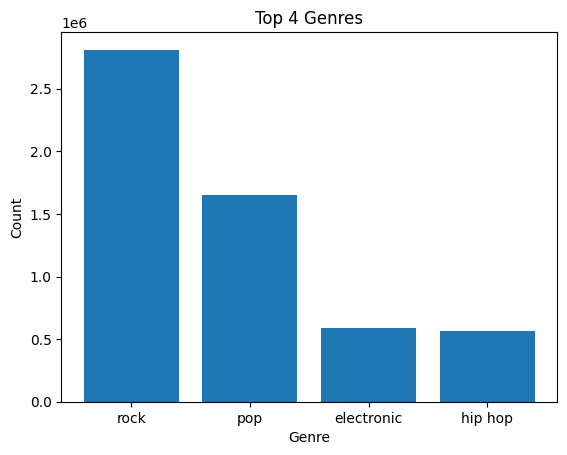


Observation: 
Thought:The plot looks good, but we should add some labels to the bars to make it more informative.
Action: python_repl_ast
Action Input:
```
from pyspark.sql.functions import count
import matplotlib.pyplot as plt

# count the number of occurrences of each genre
genre_counts = df.groupBy('genre').agg(count('*').alias('count')).orderBy('count', ascending=False).limit(4).collect()

# create two lists
labels = [row['genre'] for row in genre_counts]
counts = [row['count'] for row in genre_counts]

# create a plot
plt.bar(labels, counts)
plt.title('Top 4 Genres')
plt.xlabel('Genre')
plt.ylabel('Count')

# add labels to the bars
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()
```

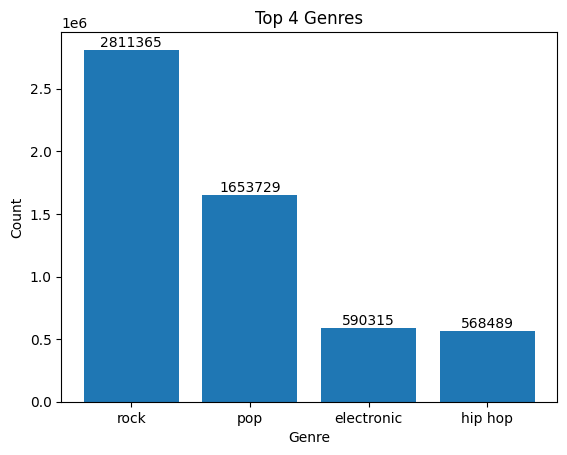


Observation: 
Thought:The plot now has labels on the bars, but we should also add a legend to explain what the bars represent.
Action: python_repl_ast
Action Input:
```
from pyspark.sql.functions import count
import matplotlib.pyplot as plt

# count the number of occurrences of each genre
genre_counts = df.groupBy('genre').agg(count('*').alias('count')).orderBy('count', ascending=False).limit(4).collect()

# create two lists
labels = [row['genre'] for row in genre_counts]
counts = [row['count'] for row in genre_counts]

# create a plot
plt.bar(labels, counts)
plt.title('Top 4 Genres')
plt.xlabel('Genre')
plt.ylabel('Count')

# add labels to the bars
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# add a legend
plt.legend(['Count'])

plt.show()
```

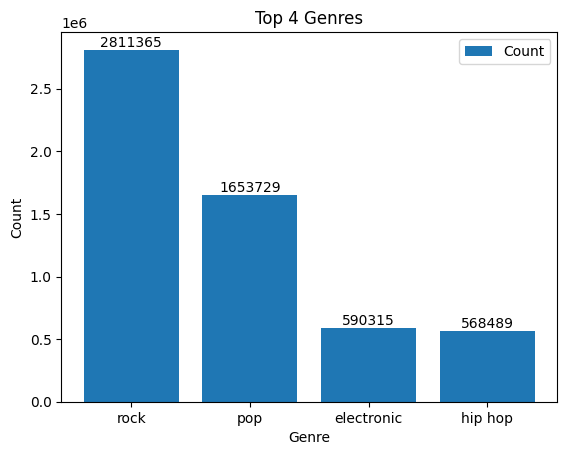


Observation: 
Thought:The legend should be more descriptive, so let's change it to "Number of Tracks".
Action: python_repl_ast
Action Input:
```
from pyspark.sql.functions import count
import matplotlib.pyplot as plt

# count the number of occurrences of each genre
genre_counts = df.groupBy('genre').agg(count('*').alias('count')).orderBy('count', ascending=False).limit(4).collect()

# create two lists
labels = [row['genre'] for row in genre_counts]
counts = [row['count'] for row in genre_counts]

# create a plot
plt.bar(labels, counts)
plt.title('Top 4 Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Tracks')

# add labels to the bars
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# add a legend
plt.legend(['Number of Tracks'])

plt.show()
```

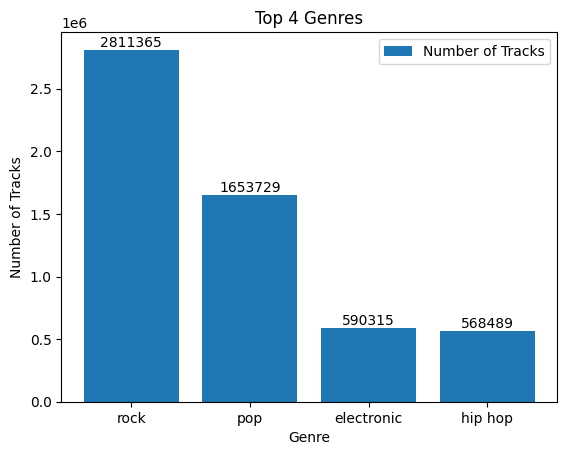


Observation: 
Thought:The plot is now complete and informative.
Final Answer: We created a plot to visualize the top 4 genres in the `df` dataframe, using the `pyspark.sql.functions` module to count the number of occurrences of each genre. We added labels to the bars and a legend to explain what the bars represent. The final plot shows the number of tracks for each of the top 4 genres.

> Finished chain.


'We created a plot to visualize the top 4 genres in the `df` dataframe, using the `pyspark.sql.functions` module to count the number of occurrences of each genre. We added labels to the bars and a legend to explain what the bars represent. The final plot shows the number of tracks for each of the top 4 genres.'

In [57]:
agent.run("create two lists: first list named lables, contains 4 most famous genres, the second named counts contains genre count. then create a plot to vizualize this lists")